In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import figure
from scipy.spatial.distance import euclidean as eu
import math
from scipy import signal

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing

import Data_load as dl
import Print_statements as ps
import length_based_confusion_mat as c_mat

## Exploring the data:

The data we have is from the following research paper: [Screening for Dyslexia Using Eye Tracking during Reading](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5147795/)

The authors of the paper had used techniques for extracting features like succades and fixations. They used SVMs for classification purposes, which is a supervised learning method. 

Our aim here was to let the system use it's computational power to determine the the 2 types of candidates appart. We intended on using a non-supervised learning method to allow the data to separate itself rather than provide it with final results which it would use to immprove the accuracy. We have mainly focused on K-Means for classification purposes.

It has data of:
1. 98 Dyslexic Candidates
2. 88 Control Candidates 

Structure of the data:

The data describes the exact location of focus for the individual. For each candidate we have the position of the left and right eye in the x-y coordinate plane. Data vectors for each candidate:
1. X coordinate of left eye -> LX
2. Y coordinate of left eye -> LY
3. X coordinate of right eye -> RX
4. Y coordinate of right eye -> RY

Importing data:

In [2]:
feature_list=['LX', 'LY', 'RX', 'RY']
C_data, D_data = dl.get_data()
Full_data = [C_data, D_data]

#### Looking at the data:

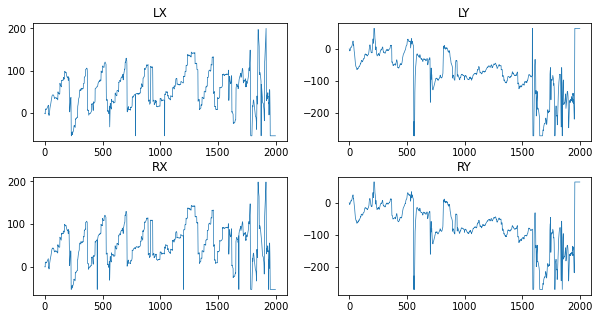

In [3]:
#print entire data of one candidate
#you can plot of any candidate using the following function:
ps.plot_entire_candidate(1, 45, Full_data) #(0-Control 1-Dyslexic, number of the candidate)

## Understanding the data

Tried recognizing the patterns in the data

#### 1. Found very obvious dips in the x-axis data - representing ends of lines:


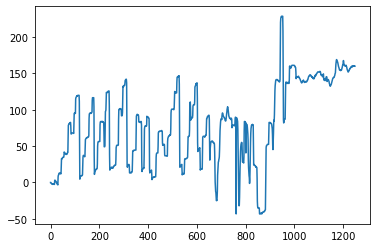

In [4]:
#printing x-axis data for a few random candidates:
plt.plot(C_data[4]['RX'])

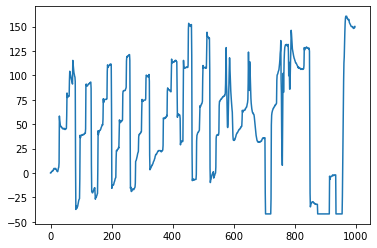

In [5]:
plt.plot(C_data[60]['RX'])

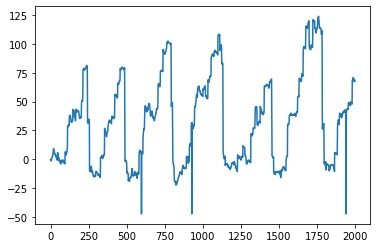

In [6]:
plt.plot(D_data[48]['RX'])

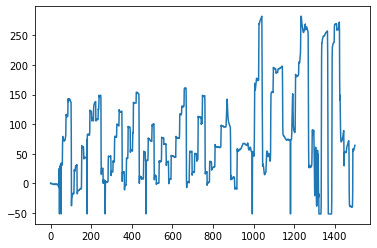

In [7]:
plt.plot(C_data[47]['RX'])

Although the dips are apparent, for most candidates it was very difficult to separate the lines (especially after the 4th-5th line). 

All candidates were asked to read the same set of lines so the number of lines for each should be the same. Even examining the graphs, it was difficult to recognize same number of lines for each candidate

#### 2.Found some inconsistencies between the left and the right eye:

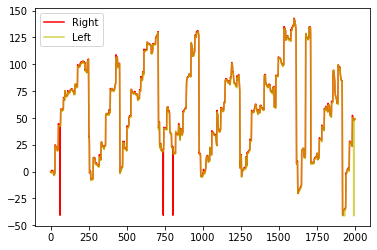

In [8]:
#ploting few left and right eye readings:
ps.plot_left_right(1, 89, Full_data, 'X')

In this specific example, the right eye reading and the left eye reading has been plotted using red and yellow lines respectively. The orange part represents the part where the 2 lines perfectly intersect with each other. 

But there are few instances of yellow and red. These are the places where the values of the left and right eye don't intersect.

Solution: To remove inconsistency and to have only one set of values, we averaged the values of the left and the right eye.  

In [9]:
x_y_data = dl.average_l_r(D_data[80])

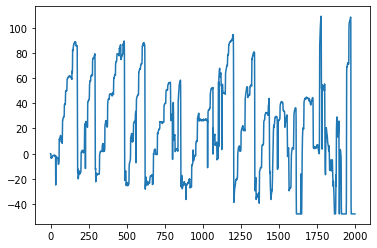

In [10]:
plt.plot(x_y_data['X'])

## Data Manipulations:
Representing the data of each candidate as a single vector. Combining all vectors in the following order:

LX LY RX RY 

In [11]:
import Data_manipulation as dm

In [12]:
full_data = dm.original_vector(C_data[2])

In [13]:
len(C_data[2]['LX'])

1249

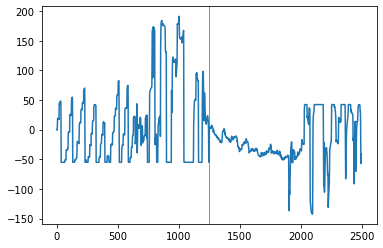

In [14]:
plt.plot(full_data)
plt.axvline(1249, linewidth = 0.7)

The main issue faced was the inconsistencies in the lengths of data available. Tried equalizing the lengths of the vectors and then applied K-means for classification.

### Different attempts to normalize the lengths of the data vectors for analysis:
#### 1.Padding at the end: 
Combined all the data vectors (X, Y) one after the other into a single vector. Added 0s or avg of all values towards the end to match the length of the longest vector. 

In [15]:
padding = dm.padding_at_last(C_data[2])

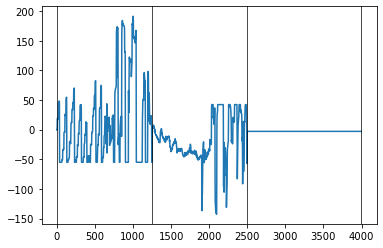

In [16]:
plt.plot(padding)
plt.axvline(1249, linewidth = 0.7, c = 'k')
plt.axvline(1249*2, linewidth = 0.7, c = 'k')
plt.axvline(0, linewidth = 0.7, c = 'k')
plt.axvline(len(padding), linewidth = 0.7, c = 'k')

Applying K-means:

In [17]:
all_candidates = []
for categ in [D_data, C_data]:
    for data_set in categ:
        all_candidates.append(dm.padding_at_last(data_set))

In [18]:
kmeans = KMeans(n_clusters = 2, random_state=0).fit(all_candidates)

predicted_labels = kmeans.labels_
actual_labels = np.concatenate((np.ones(98), np.zeros(88)))

In [19]:
acc = accuracy_score(actual_labels,predicted_labels)*100

In [20]:
100-acc

73.11827956989248

In [21]:
#confusion matrix of sets of different lengths of candidates
c_mat.conf_mat(actual_labels, predicted_labels)

array([[[ 0,  0],
        [ 6,  5]],

       [[ 0,  0],
        [ 4,  6]],

       [[ 1,  1],
        [32, 22]],

       [[ 0,  0],
        [ 0,  1]],

       [[10, 76],
        [17,  5]]])

#### Problem faced:
Because each candidate's data is of different length, what happens here is that the particular reading at specific times for each candidates don't align with the rest. 

Eg. considering 2 candidates who's data lengths are 1249 and 1749 respectively. The LX of the first will end at 1249th position in the final vector and the 1250th position will be filled by the 1st value of the LY vector. But for the second one, the 1250th position will still be filled by a reading from the LX vector. When applying k-means the algorithm will compare the 1250th vector of each candidate irrespectively. This will be a problem as different features will get compared with each other for different candidates. 

Also, because of the distribution of data lengths among the dyslexic and control candidates the K-Means algorithm relied on the length of the data for classification. 

The distribution of data lenghts is as following:

Dyslexic candidates:
1. 1499   ->   2   
2. 1999   ->   96 
 
Control candidates :
1. 999      ->   11
2. 1249   ->   10
3. 1499   ->   54
4. 1749   ->   1
5. 1999   ->   12
In the confusion matrix we can see that most of the shorter lenghted vectors are getting categorized as control and longer ones as dyslexic. As most dyslexic and only 12 of the control are longer lengthed the accuracy is considerably okay, but tbe algorithm is relying on the lengths of data and probably not on the data itself to perform classification.  

#### 2.Padding in between: 
To solve the previous conundrum, we decided to padd each feature separately and then combine them together. 

In [22]:
padding = dm.padding_in_bw(C_data[2])

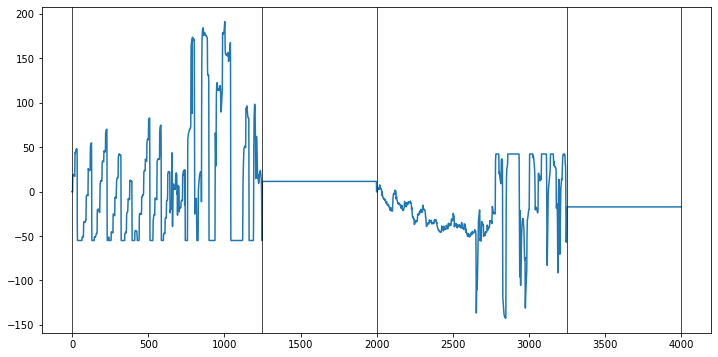

In [23]:
plt1 = plt.figure(figsize=(12,6))
plt.plot(padding)
plt.axvline(1249, linewidth = 0.7, c = 'k')
plt.axvline(len(padding)/2, linewidth = 0.7, c = 'k')
plt.axvline(1249 + len(padding)/2, linewidth = 0.7, c = 'k')
plt.axvline(len(padding), linewidth = 0.7, c = 'k')
plt.axvline(0, linewidth = 0.7, c = 'k')

In [24]:
all_candidates = []
for categ in [D_data, C_data]:
    for data_set in categ:
        all_candidates.append(dm.padding_in_bw(data_set))

In [25]:
kmeans = KMeans(n_clusters = 2, random_state=0).fit(all_candidates)

predicted_labels = kmeans.labels_
actual_labels = np.concatenate((np.ones(98), np.zeros(88)))

In [26]:
acc = accuracy_score(actual_labels,predicted_labels)*100

In [27]:
acc

50.0

In [28]:
c_mat.conf_mat(actual_labels, predicted_labels)

array([[[ 0,  0],
        [ 6,  5]],

       [[ 0,  0],
        [ 4,  6]],

       [[ 1,  1],
        [18, 36]],

       [[ 0,  0],
        [ 0,  1]],

       [[31, 55],
        [ 9, 13]]])

#### Problem faced:
Here we can see that candidates get segregared almost randomly. 

#### 3.Interpolation: 
Added data points at regular intervals by taking the average of the adjacent values. Eg. to make the 1000 length vector into a 2000 length vector, a point was added after each data point by averaging the previous and the next values.

In [29]:
padding = dm.interpolating(C_data[2])

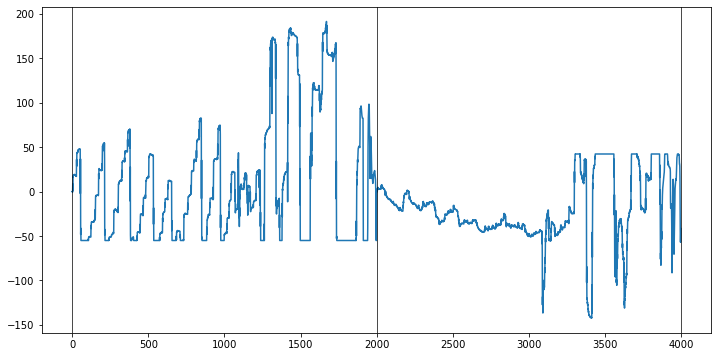

In [30]:
plt1 = plt.figure(figsize=(12,6))
plt.plot(padding)
plt.axvline(1999, linewidth = 0.7, c = 'k')
plt.axvline(1999*2, linewidth = 0.7, c = 'k')
plt.axvline(0, linewidth = 0.7, c = 'k')

In [31]:
all_candidates = []
for categ in [D_data, C_data]:
    for data_set in categ:
        all_candidates.append(dm.interpolating(data_set))

In [32]:
kmeans = KMeans(n_clusters = 2, random_state=0).fit(all_candidates)

predicted_labels = kmeans.labels_
actual_labels = np.concatenate((np.ones(98), np.zeros(88)))

In [33]:
acc = accuracy_score(actual_labels,predicted_labels)*100

In [34]:
100-acc

51.61290322580645

In [35]:
c_mat.conf_mat(actual_labels, predicted_labels)

array([[[ 0,  0],
        [ 6,  5]],

       [[ 0,  0],
        [ 6,  4]],

       [[ 2,  0],
        [36, 18]],

       [[ 0,  0],
        [ 1,  0]],

       [[53, 33],
        [14,  8]]])

#### Problem with approach:
Here we had added a lot of assumed data. The reality that few candidates read the text faster got distorted in trying to balance out the vector lengths of classification. 

#### 4.Exterpolation: 
Tried reducing the length of all vectors to match the shortest vector. Removed a data point after fixed intervals. Eg: to convert the 2000 length vector to 1000 length vector, every second reading was removed.

In [36]:
padding = dm.exterpolation(C_data[2])

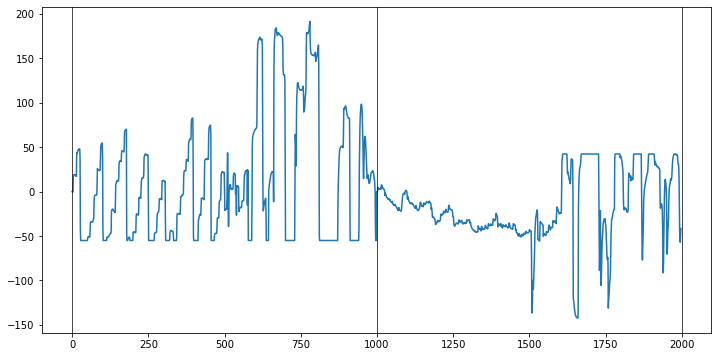

In [37]:
plt1 = plt.figure(figsize=(12,6))
plt.plot(padding)
plt.axvline(2000, linewidth = 0.7, c = 'k')
plt.axvline(1000, linewidth = 0.7, c = 'k')
plt.axvline(0, linewidth = 0.7, c = 'k')

In [38]:
all_candidates = []
for categ in [D_data, C_data]:
    for data_set in categ:
        all_candidates.append(dm.exterpolation(data_set))

In [39]:
kmeans = KMeans(n_clusters = 2, random_state=0).fit(all_candidates)

predicted_labels = kmeans.labels_
actual_labels = np.concatenate((np.ones(98), np.zeros(88)))

In [40]:
acc = accuracy_score(actual_labels,predicted_labels)*100

In [41]:
100  - acc

51.075268817204304

In [42]:
c_mat.conf_mat(actual_labels, predicted_labels)

array([[[ 0,  0],
        [ 6,  5]],

       [[ 0,  0],
        [ 4,  6]],

       [[ 0,  2],
        [17, 37]],

       [[ 0,  0],
        [ 0,  1]],

       [[30, 56],
        [10, 12]]])

#### Problem with approach:
Here we removed a lot of maybe important information. Also the same problem as before - the reality that few candidates read the text faster got distorted in trying to balance out the vector lengths of classification. 

## Black and white distance visualizations: 
To visualize the distance of different vectors from each other by using a matrix of different shades of gray. We took 2 sets of random candidates the entire data set. Calculated the distances of each candidate in the first set to each in the second set and represented them with shades of grey between white(max distance) and black(no distance).  

In [43]:
#selecting candidates:
set1 = [D_data[6], D_data[3], D_data[23], D_data[43], D_data[64]]
set2 = [C_data[63], C_data[23], C_data[43], C_data[3], C_data[14]]

#using padding at the end to equalize lengths (any method can be used):
new_set1 = []
new_set2 = []

for i in set1:
    new_set1.append(dm.padding_at_last(i))
for i in set2:
    new_set2.append(dm.padding_at_last(i))   

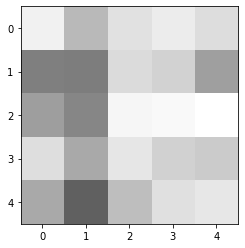

In [44]:
ps.return_sq_im(new_set1, new_set2)

Here each intersection/pixel represents the distance between the corresponding vectors.

Eg. the pixel at (4,1) represents the distance between the 4th vector of the first set and the 1st vector of hte second set which are D_data[43] and C_datat[23]. It's the darkest one in the set which means that the equalized vectors of the 2 are quite close to each other. 

Ideally we want the intersection of the vectors of the same category(dyslexic or control) to be darker and the one's between differenct categories to be lighter in shade. 